In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
pd.set_option('display.max_colwidth',None)

# Data Preparation

In [14]:
country_df=pd.read_csv("Country-data.csv")
country_df.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [15]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [16]:
# checking null values
(country_df.isnull().any()/len(country_df))*100

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [17]:
country_df.loc[country_df.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


#### No Duplicate Data and null value is found

# Data Processing

In [18]:
# In Data Dictionary it mentioned that some colums have percentage value hence a method to convert percentage to absolute
def per_to_abs(col1, col2):
    cal=(col1*col2/100)
    return cal

In [19]:
country_df['exports']=per_to_abs(country_df['exports'],country_df['gdpp'])
country_df['health']=per_to_abs(country_df['health'],country_df['gdpp'])
country_df['imports']=per_to_abs(country_df['imports'],country_df['gdpp'])

In [20]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


# Exploratory Data Analysis

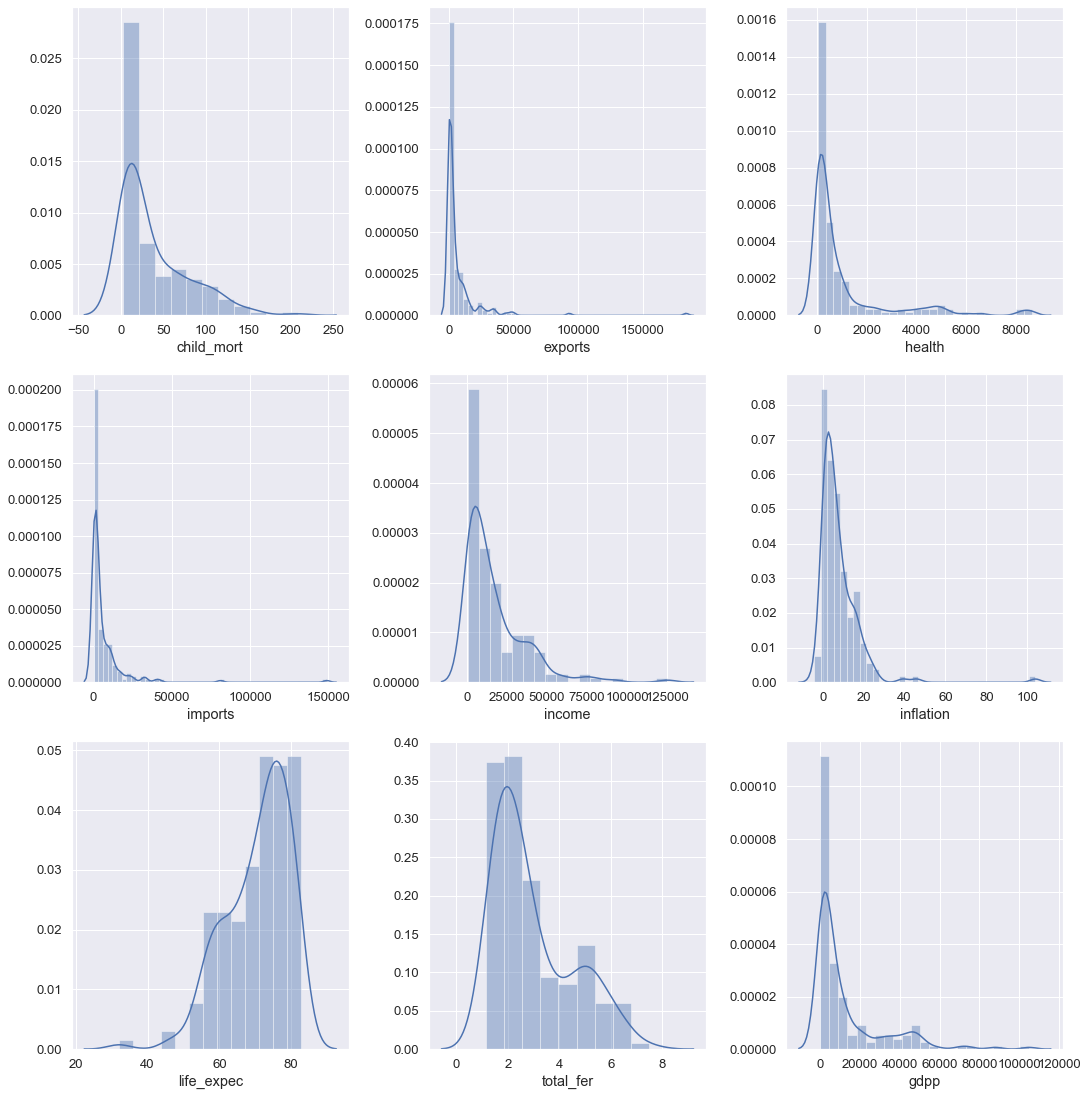

In [21]:
plt.figure(figsize=(15,20))
sns.set(font_scale=1.2)
cols =country_df.columns[1:]
plot=1
for i in cols:
    plt.subplot(4,3,plot)
    sns.distplot(country_df[i])
    plot+=1
plt.tight_layout()
plt.savefig('Features_dist.png',dpi=300,transparent=True)
plt.show()


In [22]:
country_df.agg(['mean','std','median'],).transpose()

,mean,std,median
child_mort,38.270060,40.328931,19.300
exports,7420.618847,17973.885795,1777.440
health,1056.733204,1801.408906,321.886
imports,6588.352108,14710.810418,2045.580
income,17144.688623,19278.067698,9960.000
inflation,7.781832,10.570704,5.390
life_expec,70.555689,8.893172,73.100
total_fer,2.947964,1.513848,2.410
gdpp,12964.155689,18328.704809,4660.000


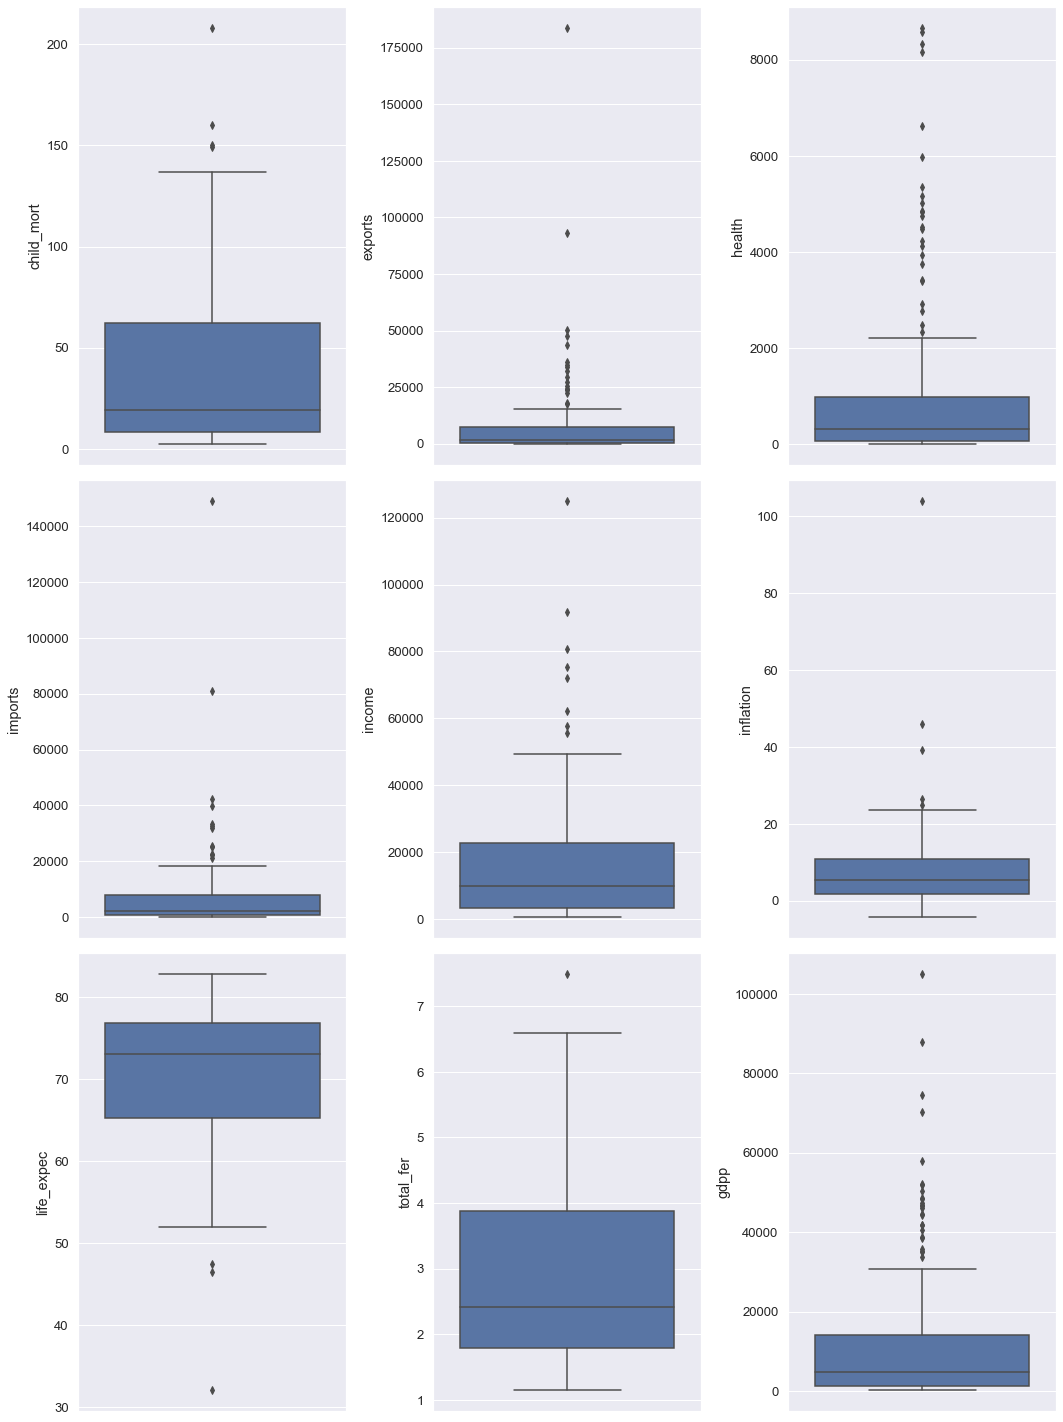

In [23]:
# checking for outliers

plt.figure(figsize=(15,20))
sns.set(font_scale=1.2)
plot=1
for i in cols:
    plt.subplot(3,3,plot)
    sns.boxplot(y=country_df[i])
    plot+=1
plt.tight_layout()
plt.show()

### We have Outliers Which need to be treated
 we have Outliers in lower end also if we remove lower end outliers we can miss some countries which really need aid  hence we will keep lower end outliers and for child_mort we will keep upper end outliers

In [27]:
#removing upper end outliers for columns other than mortality
# for col in cols:
    
#     Q1 = country_df[col].quantile(0.05)
#     Q3 = country_df[col].quantile(0.95)
#     IQR = Q3 - Q1
#     if col != 'child_mort':
#         country_df =country_df[(country_df[col] <= Q3 + 1.5*IQR)]   
#     else:
#         country_df =country_df[(country_df[col] >= Q1 - 1.5*IQR)]

# data_help['child_mort'][data_help['child_mort'] <= percentiles[0]] = percentiles[0]
# data_help['child_mort'][data_help['child_mort'] >= percentiles[1]] = percentiles[1]


# percentiles = data_help['child_mort'].quantile([0.05,0.95]).values
 
        

E:\python\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\python\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
# checking loss of columns 
country_df.shape


(163, 10)

#### Before Outliers handling we have 167 rows now we have 163, so we don't loss much data

In [102]:
# making new dataframe after scaling data
scaler=StandardScaler()
scale_df=pd.DataFrame(scaler.fit_transform(country_df.iloc[:,1:]))
scale_df.columns = country_df.columns[1:]

In [103]:
scale_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.303466,-0.617617,-0.562023,-0.648685,-0.892037,0.289329,-1.612381,1.911315,-0.702455
1,-0.545781,-0.496897,-0.431204,-0.422310,-0.367608,-0.370665,0.666389,-0.870331,-0.483620
2,-0.276937,-0.434045,-0.478624,-0.498742,-0.180401,1.177320,0.689063,-0.043175,-0.460727
3,2.027084,-0.380154,-0.528049,-0.483915,-0.621628,2.017312,-1.170232,2.138116,-0.518267
4,-0.704073,-0.008898,-0.160414,0.254178,0.210399,-0.777327,0.723074,-0.550142,0.018150


In [104]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [105]:
#hopkins calculation
hopkins(scale_df)

0.9102373347649807

[813.4883316739505, 537.5389247376185, 445.26819566950667, 387.15801985730536, 335.8092537430201, 298.35018876180357, 268.7730545968086]


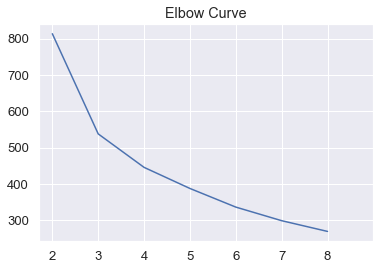

In [106]:
# creating elbow curve
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scale_df)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
print(ssd)
plt.plot(ssd)
plt.xticks([0,1,2,3,4,5,6,7],labels=['2','3','4','5','6','7','8'])
plt.title("Elbow Curve")
plt.savefig('elbow_curve.png',dpi=300,transparent=True)
plt.show()

### From elbow curve we can say that cluster equal to 3 and 4 will be good idea let's check silhoutte score

In [107]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scale_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(scale_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.47582164792275383
For n_clusters=3, the silhouette score is 0.3990749120733062
For n_clusters=4, the silhouette score is 0.38811074109023863
For n_clusters=5, the silhouette score is 0.3531488364543678
For n_clusters=6, the silhouette score is 0.29250448500102344
For n_clusters=7, the silhouette score is 0.30698659665068667
For n_clusters=8, the silhouette score is 0.3199541756245551


#### We can go for cluster = 3, as silhoutte score is high 

In [108]:
# Final k-means algo for cluster =3
kmeans = KMeans(n_clusters=3,random_state=100)
kmeans.fit(scale_df)
cluster_labels = kmeans.labels_

In [109]:
# creating copy of country  dataframe
country_df_copy=country_df.copy()
country_df_copy.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [110]:
# adding cluster from k-means
country_df_copy['kmeans_cluster']=cluster_labels
country_df_copy.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


# Cluster Profilng

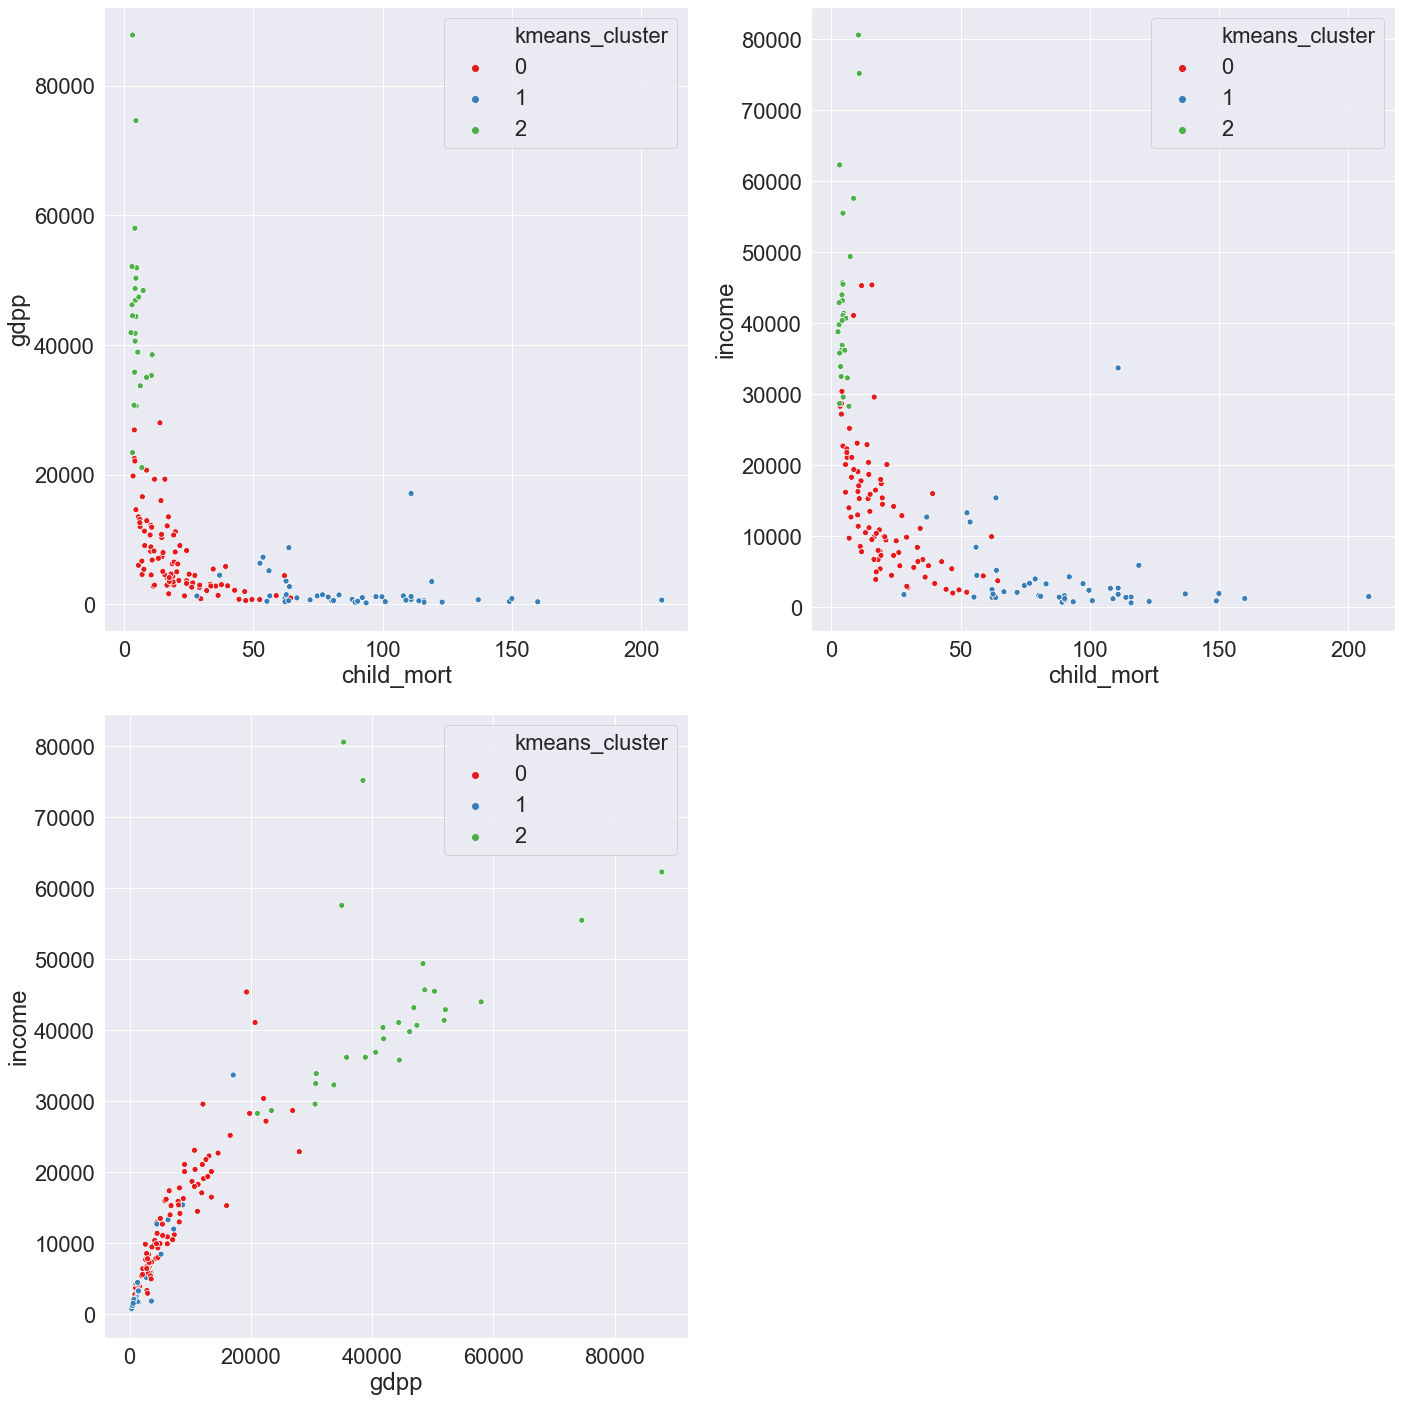

In [111]:
# plotting scatter plot between gdpp,child_mort,income
plt.figure(figsize=(20,20))
sns.set(font_scale=2)
plt.subplot(2,2,1)
sns.scatterplot(x='child_mort',y='gdpp',hue='kmeans_cluster',data=country_df_copy,palette='Set1')
plt.subplot(2,2,2)
sns.scatterplot(x='child_mort',y='income',hue='kmeans_cluster',data=country_df_copy,palette='Set1')
plt.subplot(2,2,3)
sns.scatterplot(x='gdpp',y='income',hue='kmeans_cluster',data=country_df_copy,palette='Set1')
plt.tight_layout()
plt.savefig('scatterplot.png',dpi=300,transparent=True)
plt.show()

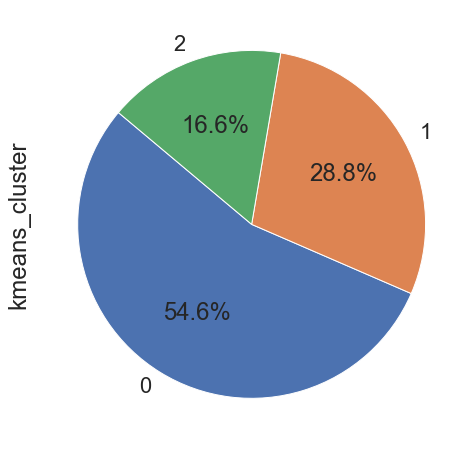

In [112]:
# checking value counts in cluster 
plt.figure(figsize=(8,8))
sns.set(font_scale=2)
value_counts_cluster=country_df_copy['kmeans_cluster'].value_counts().plot.pie( 
autopct='%1.1f%%',labels=[0,1,2], startangle=140)
plt.savefig('pie.png',dpi=300,transparent=True)

In [113]:
country_df_copy['kmeans_cluster'].value_counts()

0    89
1    47
2    27
Name: kmeans_cluster, dtype: int64

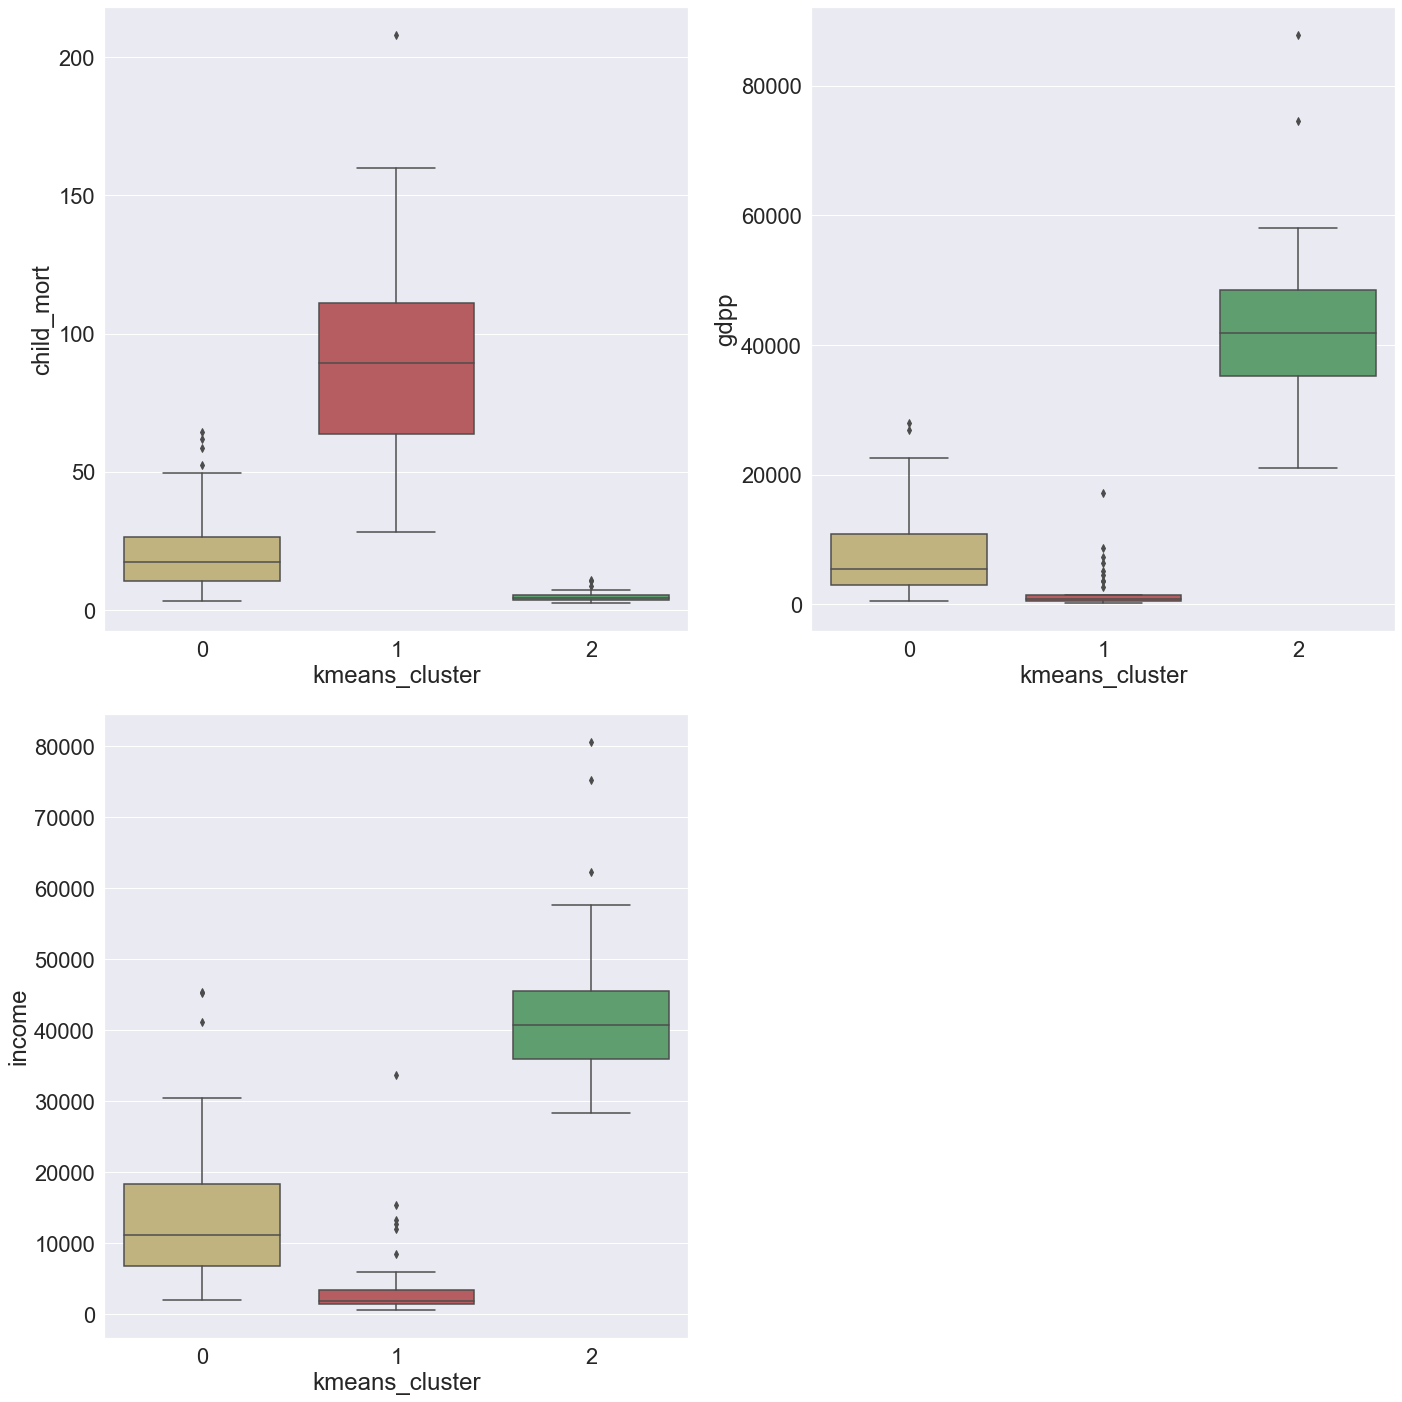

In [114]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=country_df_copy['child_mort'],x=country_df_copy['kmeans_cluster'],palette=['y','r','g'])
plt.subplot(2,2,2)
sns.boxplot(y=country_df_copy['gdpp'],x=country_df_copy['kmeans_cluster'],palette=['y','r','g'])
plt.subplot(2,2,3)
sns.boxplot(y=country_df_copy['income'],x=country_df_copy['kmeans_cluster'],palette=['y','r','g'])
plt.tight_layout()
plt.savefig('boxplot',dpi=300,transparent=True)
plt.show()

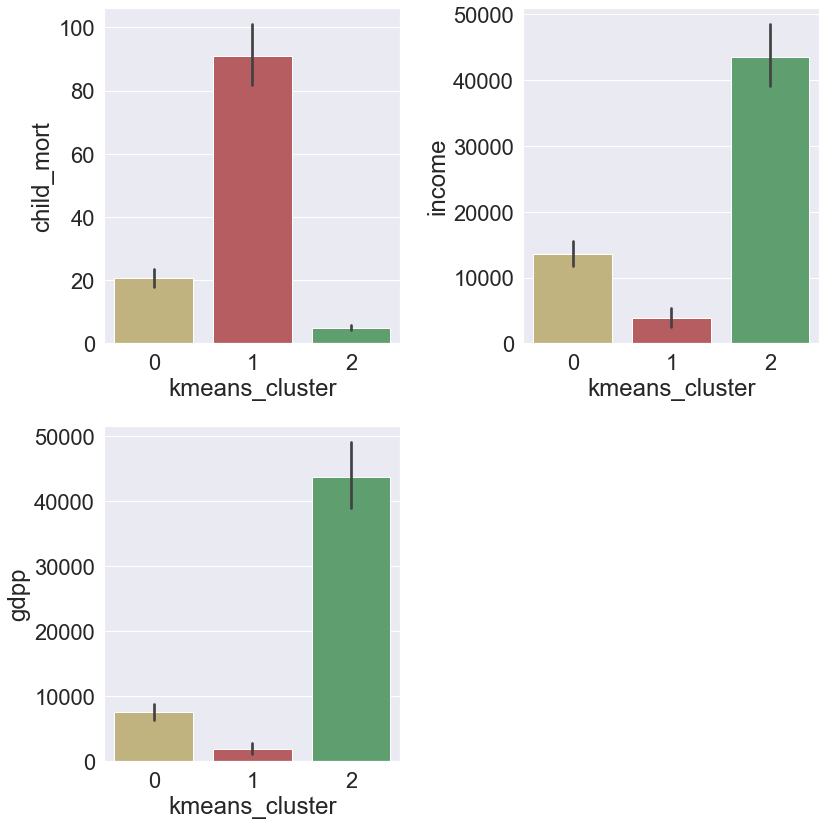

In [115]:
plt.figure(figsize=(12,12))
plt.tight_layout() 
plt.subplot(2,2,1)
sns.barplot(y='child_mort',x='kmeans_cluster',data=country_df_copy,palette=['y','r','g'])
plt.subplot(2,2,2)
sns.barplot(y='income',x='kmeans_cluster',data=country_df_copy,palette=['y','r','g'])
plt.subplot(2,2,3)
sns.barplot(y='gdpp',x='kmeans_cluster',data=country_df_copy,palette=['y','r','g'])
plt.tight_layout()
plt.show()

# If We see above Boxplot and Bar plot we can say that:-

We have 47 countries in cluster 1  that can needs aid because in 

cluster 1 country child mortality is high, 

gdpp and income is low

hence providing aid to these country will good.

# Herarachical Clustering

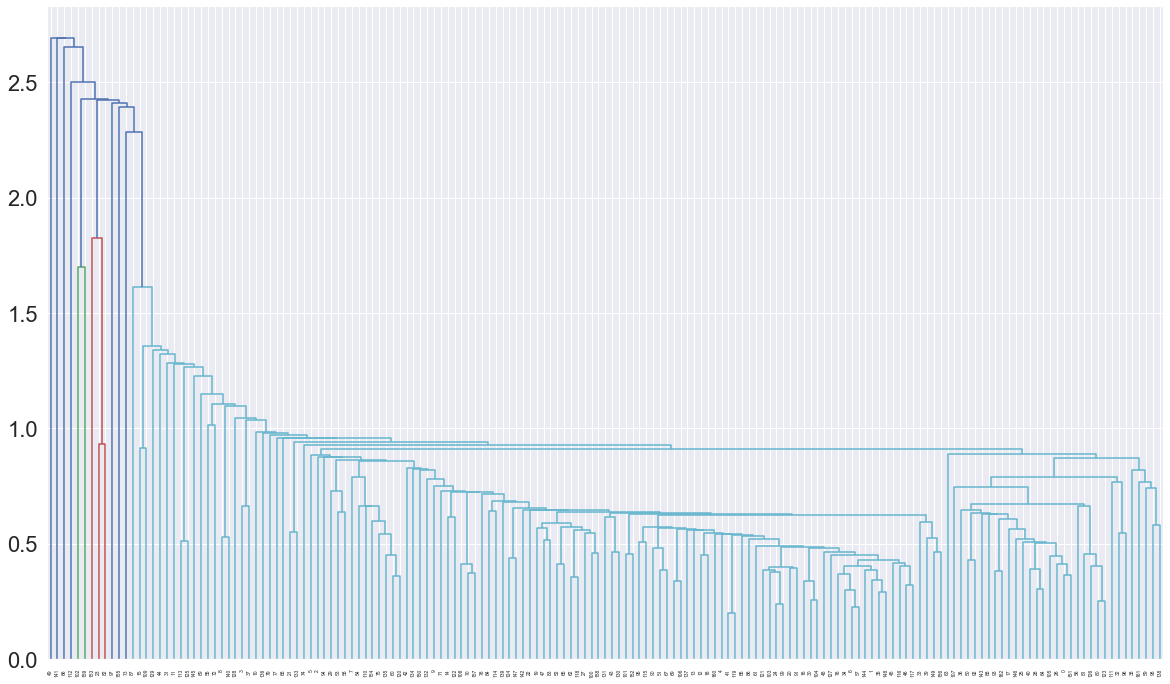

In [116]:
# Doing Hierarachical clustering with single linkage
plt.figure(figsize=(20,12))
merging=linkage(scale_df,method='single')
dendrogram(merging)
plt.savefig('single',dpi=300,transparent=True)
plt.show()

#### We can see that its hard to find any cluster number let's do with complete linkage

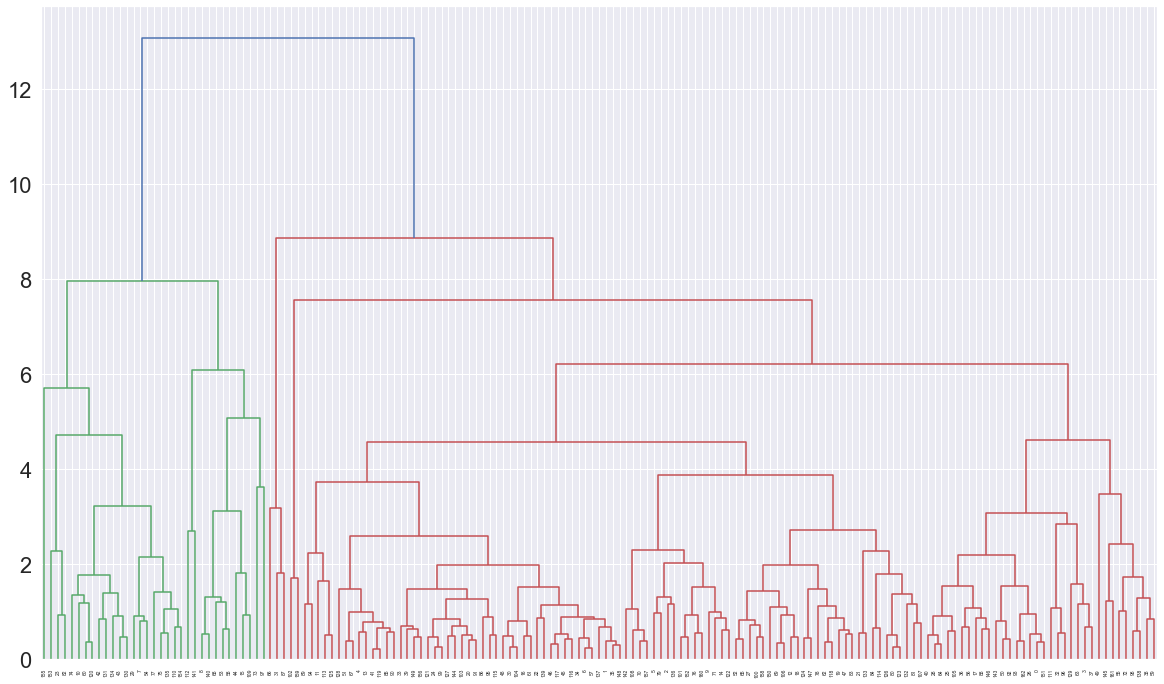

In [117]:
plt.figure(figsize=(20,12))
merging=linkage(scale_df,method='complete')
dendrogram(merging)
plt.savefig('complt',dpi=300,transparent=True)
plt.show()

In [118]:
cluster_labels = cut_tree(merging,n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0])

In [119]:
country_df_copy['cluster_hierarachy']=cluster_labels

In [120]:
country_df_copy.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,cluster_hierarachy
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0


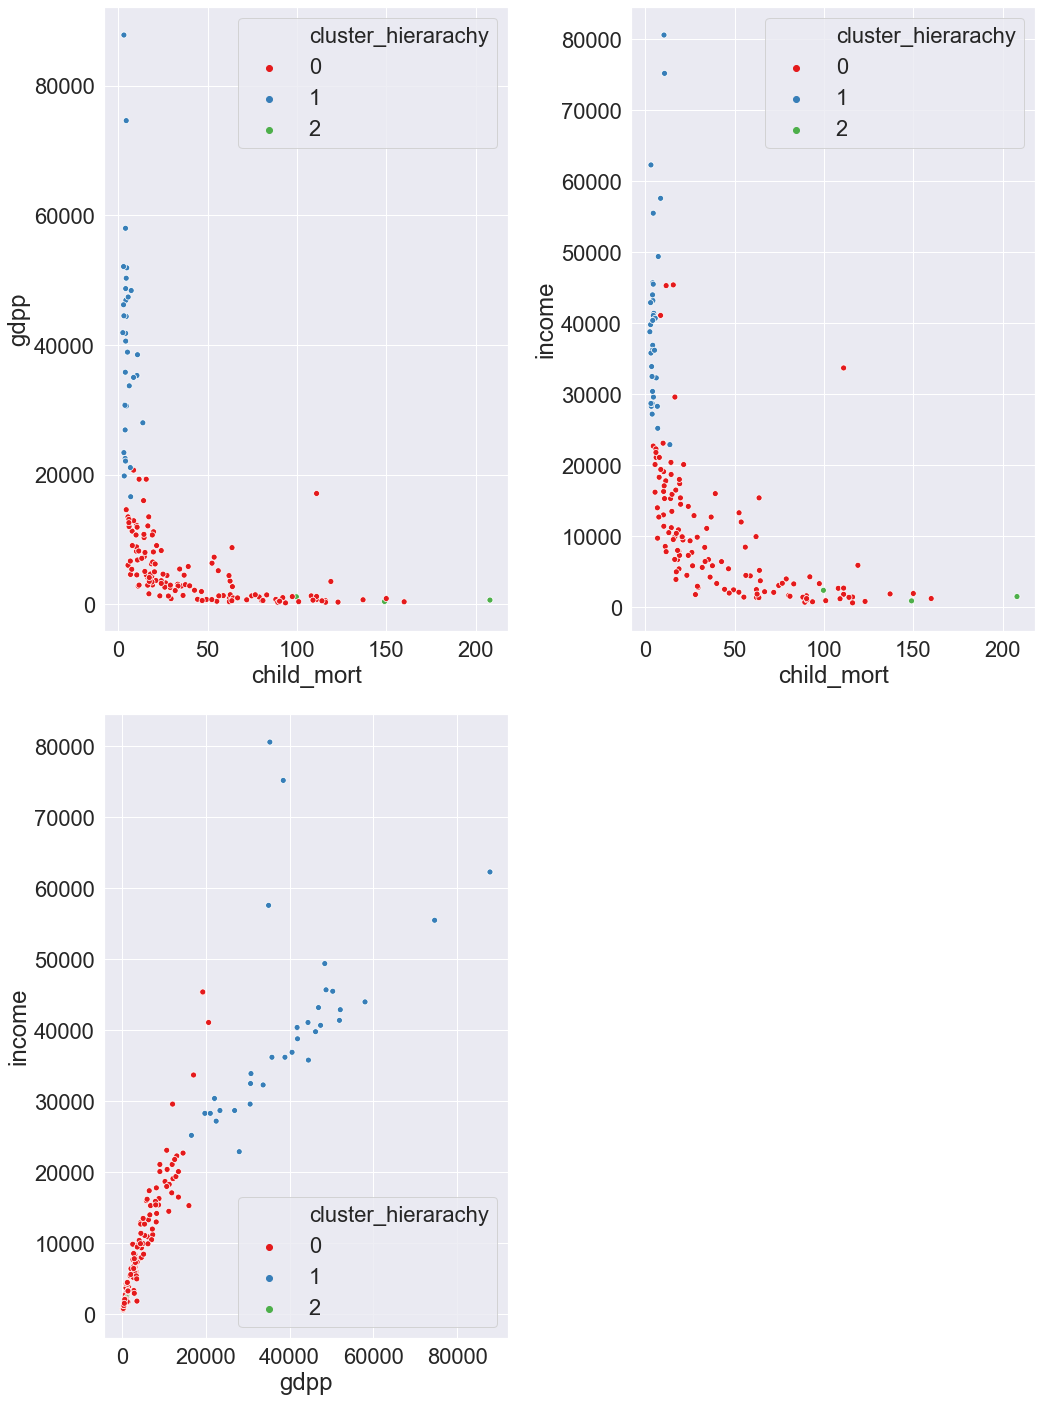

In [121]:
# plotting scatter plot 
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
sns.scatterplot(x='child_mort',y='gdpp',hue='cluster_hierarachy',data=country_df_copy,palette='Set1')
plt.subplot(2,2,2)
sns.scatterplot(x='child_mort',y='income',hue='cluster_hierarachy',data=country_df_copy,palette='Set1')
plt.subplot(2,2,3)
sns.scatterplot(x='gdpp',y='income',hue='cluster_hierarachy',data=country_df_copy,palette='Set1')
plt.tight_layout()
plt.show()


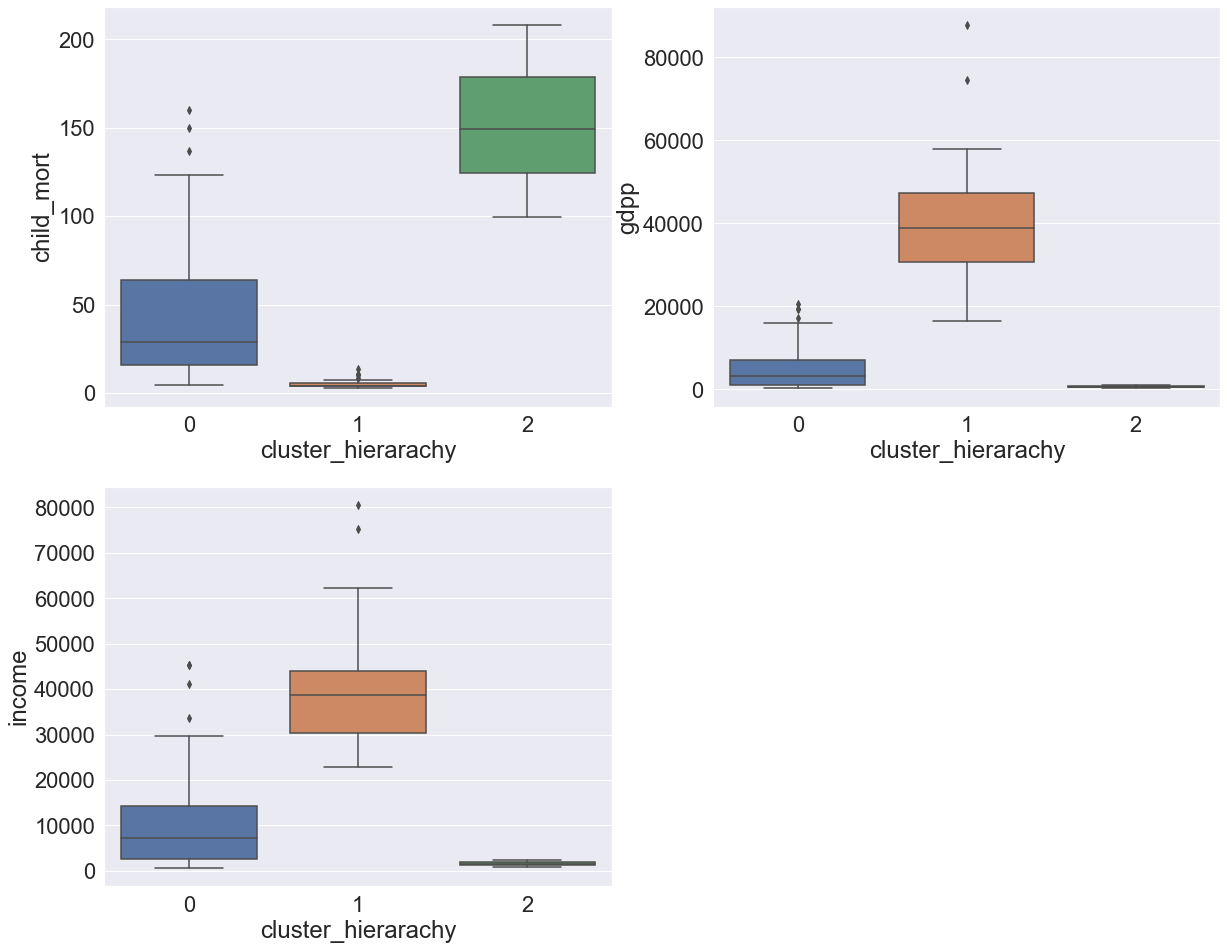

In [122]:
plt.figure(figsize=(20,25))
plt.subplot(3,2,1)
sns.boxplot(y=country_df_copy['child_mort'],x=country_df_copy['cluster_hierarachy'])
plt.subplot(3,2,2)
sns.boxplot(y=country_df_copy['gdpp'],x=country_df_copy['cluster_hierarachy'])
plt.subplot(3,2,3)
sns.boxplot(y=country_df_copy['income'],x=country_df_copy['cluster_hierarachy'])

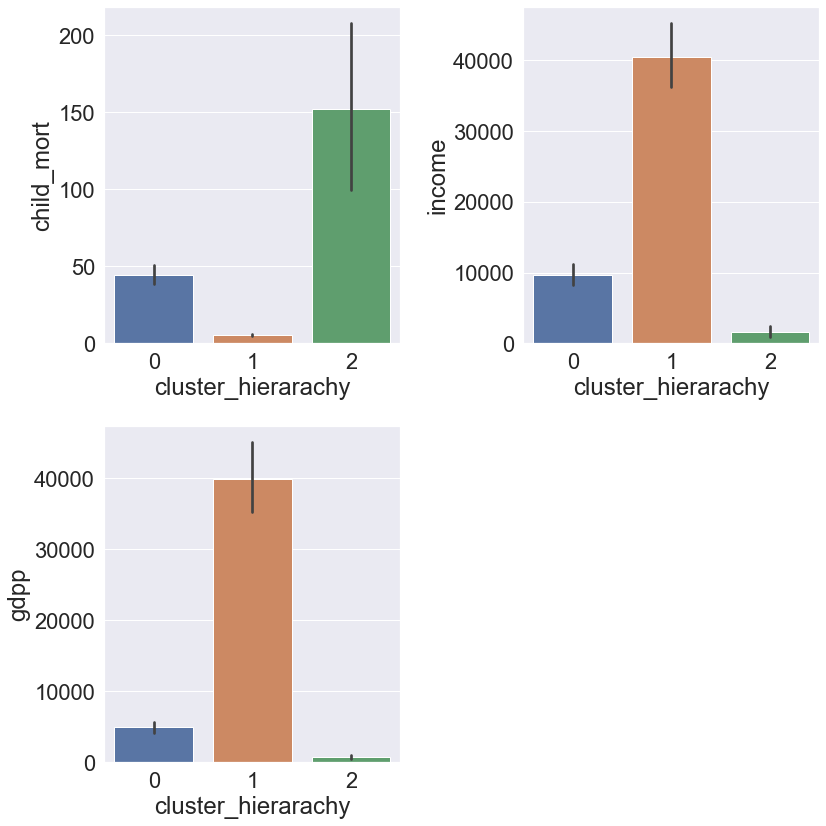

In [123]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.barplot(y='child_mort',x='cluster_hierarachy',data=country_df_copy)
plt.subplot(2,2,2)
sns.barplot(y='income',x='cluster_hierarachy',data=country_df_copy)
plt.subplot(2,2,3)
sns.barplot(y='gdpp',x='cluster_hierarachy',data=country_df_copy)
plt.tight_layout()
plt.show()

In [124]:
country_df_copy['cluster_hierarachy'].value_counts()

0    127
1     33
2      3
Name: cluster_hierarachy, dtype: int64

## In this problem we will go by clustering by k-means
#### from above analysis in cluster by k-means we have found that countries under cluster 1 about 47 countries 
#### which can need aid.

In [125]:
# Storing  countries with cluster 1 in new dataframe.
country_df_copy.drop('cluster_hierarachy',1,inplace=True)
country_aid_df=pd.DataFrame((country_df_copy[country_df_copy['kmeans_cluster']==1]))
country_aid_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
0,Afghanistan,90.2,55.300,41.9174,248.297,1610,9.440,56.2,5.82,553,1
3,Angola,119.0,2199.190,100.6050,1514.370,5900,22.400,60.1,6.16,3530,1
17,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758,1
21,Botswana,52.5,2768.600,527.0500,3257.550,13300,8.920,57.1,2.88,6350,1
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.810,57.9,5.87,575,1


In [126]:
# finding out top 5 countries which are in urgent need of aid
final_country=country_aid_df.sort_values(by=['gdpp', 'child_mort' ,'income'] ,ascending=[True,False,True]).head(5)

In [127]:
final_country

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,1
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,1
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,1
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,1
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399,1


In [128]:
# extracting coutry name and storing in list
country_name=list(final_country['country'])

In [129]:
country_name

['Burundi', 'Liberia', 'Congo, Dem. Rep.', 'Niger', 'Sierra Leone']

 ## Countries which need Urgent Aid:-
* Burundi<br> 
* Liberia<br>
* Congo, Dem. Rep <br>
* Niger<br>
* Sierra Leone <br>

Note- Sorting is done in Gdpp,child_mort, income

 <b>Conclusion</b> :- `above 5 countries are need of urgent as there gdpp is low child_mort is high people income is also low.<br>`
 
<b>Recommendation for NGO</b>:- `These are countries which need Aid Urgently to fight Poverty, NGO should porvide Aid to these countries so they can fight poverty `